In [1]:
import os
import json
import uuid
from contextlib import asynccontextmanager
from typing import TypedDict, Annotated, Optional, Literal, Any, List, AsyncGenerator
from IPython.display import display, Image

import langgraph.errors
from langgraph.checkpoint.postgres.aio import AsyncPostgresSaver
from langgraph.graph.state import CompiledStateGraph
from openai.resources.containers.files import content
from psycopg_pool import AsyncConnectionPool
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langgraph.graph import add_messages
from langgraph.types import interrupt, Command
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from sqlalchemy.ext.asyncio import create_async_engine

from agents.guidance import build_graph, provide_guidance, GuidanceHelperStdOutput
from db.db import get_session
from dto.response.grades import GradeResponseBase
from dto.response.matrix_chats import MessageDict

load_dotenv()
db_url = os.getenv("PG_VECTOR_DATABASE_URL")

LITE_LLM_API_KEY = os.getenv("OPENAI_API_KEY")
# LITE_LLM_URL = os.getenv("OPENAI_BASE_URL")
# LITE_MODEL = os.getenv("OPENAI_MODEL")

# model = ChatOpenAI(
#     model=LITE_MODEL,
#     temperature=0,
#     api_key=LITE_LLM_API_KEY,
#     base_url=LITE_LLM_URL,
#     streaming=True,
#     verbose=True,
# )
model = ChatOpenAI(
    model="gpt-4o", api_key=LITE_LLM_API_KEY, streaming=True, verbose=True
)


def multiple_values(a: Any, b: Any) -> Any:
    print("MULTIPLE VALUES FUNC")
    print(a, b)
    if a is None and b is not None:
        return b
    elif a is not None and b is None:
        return a
    return b


class AmbiguousStdOutput(BaseModel):
    is_ambiguous: bool
    question: str


class FinalClassificationStdOutput(BaseModel):
    final_class: str = Field(description="Final classification label")
    final_class_id: int = Field(description="Id of the final classification")
    message_to_the_user: str = Field(description="Message to user")


class SpellcheckBase(BaseModel):
    spelling: str
    corrected_spelling: str
    correction_applied: bool


class ReasonerOutputBase(BaseModel):
    classification: str
    classification_explanation: str
    certainty_level: int


class ReasonerState(TypedDict):
    grades: List[GradeResponseBase]
    messages: Annotated[list, add_messages]
    spellcheck_response: Optional[SpellcheckBase]
    reasoner_response: Optional[ReasonerOutputBase]
    interrupt_state: dict[str, str]
    is_ambiguous: bool
    ambiguous_output: Optional[str]
    should_admin_continue: bool
    number_of_irregularities: Optional[int]
    final_result: Optional[FinalClassificationStdOutput]


class ClassifierState(TypedDict):
    grades: Annotated[List[GradeResponseBase], multiple_values]
    msgs: Annotated[list, add_messages]
    finished_state: Annotated[str, multiple_values]
    interrupt_state: Annotated[dict[str, str], multiple_values]


classifier_builder = StateGraph(ClassifierState)


async def reasoner(state: ClassifierState) -> ClassifierState:
    message = ChatPromptTemplate.from_messages(
        (
            "system",
            """
            Based on the user question you need to categorize into one of the following categories:
            {categories}
            Respond only with the category recognized!
            """,
        )
    )
    msg = message.format(categories=state["grades"])
    model_structured = model.with_structured_output(ReasonerOutputBase)
    response = await model_structured.ainvoke(state["msgs"] + [msg])
    return {
        "msgs": [AIMessage(response.classification)],
        "finished_state": None,
        "grades": state["grades"],
        "interrupt_state": {},
    }


async def reflect(state: ClassifierState) -> ClassifierState:
    input_val = state["msgs"][-2].content
    predicted_state = state["msgs"][-1].content
    prompt_template = ChatPromptTemplate.from_template(
        """
        You are an reviewing user submission categorization of the answer of expertise in a particular subject.
        You are provided the available expertise categories to which you need to categorize into.
        Critique the prediction if you think it's incorrect!
        If you agree with correct prediction respond with exactly "finish" without any explanations!
        If you find the categorization inconclusive or not indicative in any way of the user message respond with exactly "human"!
        Expertise categories:
        {categories}
        Users message: {msg}
        Predicted user expertise: {state}
        """
    )
    prompt = await prompt_template.ainvoke(
        {"state": predicted_state, "msg": input_val, "categories": state["grades"]}
    )
    response = model.invoke(prompt)
    print("REFLECT RESPONSE", response)
    return {
        "msgs": [HumanMessage(response.content)],
        "finished_state": None,
        "grades": state["grades"],
        "interrupt_state": {},
    }


async def correct_found(
    state: ClassifierState,
) -> Literal["reasoner", "human", "finish"]:
    if state["msgs"][-1].content == "finish":
        print("CORRECT RESPONSE finish")
        return "finish"
    elif state["msgs"][-1].content == "human":
        print("CORRECT RESPONSE human")
        return "human"
    print("CORRECT RESPONSE reasoner")
    return "reasoner"


async def finish(state: ClassifierState) -> ClassifierState:
    finished_state = state["msgs"][-2].content
    print("FINISH RESPONSE", finished_state)
    return {
        "msgs": state["msgs"],
        "finished_state": finished_state,
        "grades": state["grades"],
        "interrupt_state": {},
    }


async def human(state: ClassifierState) -> ClassifierState:
    interrupt_val = {
        "answer_to_revisit": state["msgs"][-2].content,
    }
    value = interrupt(
        interrupt_val,
    )
    print("HUMAN IN THE LOOP RESPONSE")
    print("FINISH STATE HUMAN", state["finished_state"])
    return {
        "msgs": [AIMessage(value)],
        "finished_state": state["finished_state"],
        "grades": state["grades"],
        "interrupt_state": interrupt_val,
    }


classifier_builder.add_node("reasoner", reasoner)
classifier_builder.add_node("reflect", reflect)
classifier_builder.add_node("finish", finish)
classifier_builder.add_node("human", human)
classifier_builder.add_edge(START, "reasoner")
classifier_builder.add_edge("reasoner", "reflect")
classifier_builder.add_conditional_edges("reflect", correct_found)
classifier_builder.add_edge("reflect", "finish")
classifier_builder.add_edge("human", "finish")
classifier_builder.add_edge("finish", END)

classify = classifier_builder.compile()

builder = StateGraph(ReasonerState)


async def answer_classifier(state: ReasonerState) -> ReasonerState:
    response: GuidanceHelperStdOutput = None
    async for chunk in provide_guidance(state["messages"]):
        print("ANSWER RESPONSE", chunk)
        if "structured_response" in chunk:
            if isinstance(chunk["structured_response"], GuidanceHelperStdOutput):
                response = chunk["structured_response"]
    print("GUIDANCE RESPONSE", response)
    # guidance_graph = await build_graph()
    # irregularities_num = 0
    # if "number_of_irregularities" in state:
    #     if state["number_of_irregularities"] is None:
    #         irregularities_num = 0
    # response = await guidance_graph.ainvoke(
    #     {
    #         "messages": state["messages"],
    #         "irregularity_amount": irregularities_num,
    #     }
    # )
    # message_to_respond = []
    # if len(response["messages"]) > 0:
    #     message_to_respond = [response["messages"][-1]]
    #
    # print("ANSWER CATEGORIZATION", response)

    return {
        "grades": state["grades"],
        "messages": [AIMessage(response.message)],
        "number_of_irregularities": 0,
        "spellcheck_response": None,
        "reasoner_response": None,
        "interrupt_state": {},
        "is_ambiguous": False,
        "ambiguous_output": "direct" if response.has_user_answered else "indirect",
        "should_admin_continue": response.should_admin_be_involved,
        "final_result": None,
    }


async def next_step(
    state: ReasonerState,
) -> Literal["deeply_classify", "ask_clarification", "human"]:
    print("NEXT STEP")
    print(f"{state}")
    if state["should_admin_continue"]:
        return "human"
    if state["ambiguous_output"] != "direct":
        return "ask_clarification"
    return "deeply_classify"


async def ask_clarification(state: ReasonerState) -> ReasonerState:
    print("Ask clarification")
    interrupt_val = {
        "answer_to_revisit": state["messages"][-2].content,
    }
    interrupt_msg = interrupt(interrupt_val)
    return {
        "grades": state["grades"],
        "messages": [AIMessage(interrupt_msg)],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": None,
        "interrupt_state": interrupt_val,
        "is_ambiguous": state["is_ambiguous"],
        "ambiguous_output": state["ambiguous_output"],
        "number_of_irregularities": state["number_of_irregularities"],
        "should_admin_continue": state["should_admin_continue"],
        "final_result": None,
    }


async def deeply_classify(state: ReasonerState) -> ReasonerState:
    print("Deeply classify")
    async for class_chunk in classify.astream(
        {"msgs": state["messages"], "finished_state": None, "grades": state["grades"]}
    ):
        print("DEEPLY CLASSIFY RESPONSE", class_chunk)
        if (
            "finished_state" in class_chunk
            and class_chunk["finished_state"] is not None
        ):
            msg = class_chunk["finished_state"]

    return {
        "grades": state["grades"],
        "messages": [],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": state["reasoner_response"],
        "interrupt_state": {},
        "is_ambiguous": state["is_ambiguous"],
        "ambiguous_output": state["ambiguous_output"],
        "number_of_irregularities": state["number_of_irregularities"],
        "should_admin_continue": state["should_admin_continue"],
        "final_result": None,
    }


async def reasoner(state: ReasonerState) -> ReasonerState:
    prompt_template = ChatPromptTemplate.from_template(
        """
        Summarize the conversation and thank the user and show the finalized categorization emphasized!
        Use one of these categories, labels only, do not display the entire object:
        {grades}
        Do not explain yourself and prolong the conversation!
        """
    )
    prompt = prompt_template.invoke({"grades": state["grades"]})
    structured_output_model = model.with_structured_output(FinalClassificationStdOutput)
    response = structured_output_model.invoke(
        state["messages"] + [HumanMessage(prompt.to_string())]
    )
    print("REASONER RESPONSE -> ", response)
    return {
        "grades": state["grades"],
        "messages": [],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": state["reasoner_response"],
        "interrupt_state": {},
        "is_ambiguous": state["is_ambiguous"],
        "ambiguous_output": state["ambiguous_output"],
        "number_of_irregularities": state["number_of_irregularities"],
        "should_admin_continue": state["should_admin_continue"],
        "final_result": response,
    }


async def human(state: ReasonerState) -> ReasonerState:
    interrupt_val = {
        "answer_to_revisit": state["messages"][-2].content,
    }
    value = interrupt(
        interrupt_val,
    )
    print("HUMAN IN THE LOOP RESPONSE")
    return {
        "grades": state["grades"],
        "messages": [value],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": state["reasoner_response"],
        "interrupt_state": {},
        "is_ambiguous": state["is_ambiguous"],
        "ambiguous_output": state["ambiguous_output"],
        "number_of_irregularities": state["number_of_irregularities"],
        "should_admin_continue": True,
        "final_result": state["final_result"],
    }


builder.add_node("answer_classifier", answer_classifier)
builder.add_node("ask_clarification", ask_clarification)
builder.add_node("deeply_classify", deeply_classify)
builder.add_node("human", human)
builder.add_node("reasoner", reasoner)
builder.add_edge(START, "answer_classifier")
builder.add_conditional_edges("answer_classifier", next_step)
builder.add_edge("ask_clarification", "deeply_classify")
builder.add_edge("deeply_classify", "reasoner")
builder.add_edge("human", "deeply_classify")
builder.add_edge("reasoner", END)

full_graph = builder.compile()


@asynccontextmanager
async def get_checkpointer():
    checkpointer = AsyncPostgresSaver.from_conn_string(db_url)
    # Check if it's a context manager
    if hasattr(checkpointer, "__aenter__"):
        # It's a context manager, use it with async with
        async with checkpointer as checkpointer:
            yield checkpointer
    else:
        # It's the actual checkpointer
        try:
            yield checkpointer
        finally:
            await checkpointer.aclose()


@asynccontextmanager
async def get_graph() -> AsyncGenerator[CompiledStateGraph, Any]:
    async with get_checkpointer() as checkpointer:
        graph = builder.compile(checkpointer=checkpointer)
        yield graph


async def reasoner_run(
    thread_id: uuid.UUID, msgs: List[MessageDict], grades: List[GradeResponseBase]
) -> AsyncGenerator[str, Any]:
    async with get_graph() as graph:
        config = {"configurable": {"thread_id": thread_id}}
        interrupt_happened = False
        interrupt_value = ""
        processing_type = ""
        message_val = ""
        should_admin_continue = False
        async for chunk in graph.astream(
            {
                "messages": msgs,
                "grades": grades,
            },
            config,
        ):
            actual_type = list(chunk.keys())[0]
            print("async chunk", chunk)
            print("ACTUAL TYPE", actual_type)
            if actual_type == "answer_classifier":
                processing_type = "Classifying answer"
            elif actual_type == "ambiguity":
                processing_type = "Resolving ambiguity"
            elif actual_type == "__interrupt__":
                processing_type = "Interrupt"
            elif actual_type == "deeply_classify":
                processing_type = "Classifying"
            elif actual_type == "reasoner":
                processing_type = "Finalizing"
            print("PROCESSING TYPE", processing_type)
            if "__interrupt__" in chunk:
                print(f"INTERRUPT RESPONSE {chunk}")
                interrupt_happened = True
                interrupt_value = chunk["__interrupt__"][0].value["answer_to_revisit"]
                message_val = ""
            else:
                should_admin_continue = chunk[actual_type]["should_admin_continue"]
                if "final_result" in chunk[actual_type] is not None:
                    if hasattr(
                        chunk[actual_type]["final_result"], "message_to_the_user"
                    ):
                        message_val = chunk[actual_type][
                            "final_result"
                        ].message_to_the_user
                if len(chunk[actual_type]["messages"]) > 0:
                    print("WHY DO MESSAGES NEVER GO IN")
                    message_val = chunk[actual_type]["messages"][-1].content
                    print(f"MESSAGE VAL {message_val}")

            yield json.dumps(
                {
                    "type": processing_type,
                    "interrupt_happened": interrupt_happened,
                    "interrupt_value": interrupt_value,
                    "message": message_val,
                    "final_result": (
                        chunk[actual_type]["final_result"].model_dump_json()
                        if "final_result" in chunk[actual_type]
                        and isinstance(
                            chunk[actual_type]["final_result"],
                            FinalClassificationStdOutput,
                        )
                        else ""
                    ),
                    "should_admin_continue": should_admin_continue,
                }
            )


async def run_interrupted(thread_id: uuid.UUID, unblock_value: str) -> dict[str, Any]:
    async with get_graph() as graph:
        config = {"configurable": {"thread_id": thread_id}}
        state = await graph.aget_state(config)
        unblock_response = await graph.ainvoke(
            Command(resume=unblock_value), config=config
        )
        return unblock_response
    return None

In [2]:
from utils.common import convert_msg_dict_to_langgraph_format
import asyncio

grades: List[GradeResponseBase] = [
    GradeResponseBase(id=1, label="Not Informed", value=1),
    GradeResponseBase(id=2, label="Informed Basics", value=2),
    GradeResponseBase(id=3, label="Informed in Details", value=3),
    GradeResponseBase(id=4, label="Practice and Lab Examples", value=4),
    GradeResponseBase(id=5, label="Production Maintenance", value=5),
    GradeResponseBase(id=6, label="Production from Scratch", value=6),
    GradeResponseBase(id=7, label="Educator/Expert", value=7),
]

msgs: List[MessageDict] = [
    MessageDict(
        msg_type="ai",
        message="""
        Expertise in Cryptography
        Welcome, Jessica! In this discussion, we will explore your expertise in Cryptography, which focuses on implementing encryption, hashing, and secure communication protocols. Understanding the appropriate expertise level is crucial for your learning and application in the field.

        We offer various expertise grades to help you identify where you stand or where you want to grow:

        Not Informed - Basic understanding of the subject.
        Informed Basics - Familiarity with fundamental concepts.
        Informed in Details - Comprehensive knowledge of the topic.
        Practice and Lab Examples - Practical experience and demonstration.
        Production Maintenance - Hands-on experience in maintaining production systems.
        Production from Scratch - Ability to build production systems from the ground up.
        Educator/Expert - Mastery of the subject, capable of teaching others.
        Select the expertise level that resonates with your current understanding or desired growth in Cryptography, and let’s enhance your skills!
        """,
    ),
    MessageDict(
        msg_type="human",
        message="""
        bla bla bla
        """,
    ),
    MessageDict(
        msg_type="ai",
        message="""
        It seems like the response provided doesn't address the question or contribute meaningfully to the discussion.It's important to provide relevant and thoughtful answers to ensure productive communication. If there are any concerns or confusion about the topic, please feel free to ask for clarification or more information.

If this pattern of providing unrelated answers continues, we may need to escalate the matter to managers for further assistance. Your cooperation is appreciated as we strive to make this discussion beneficial for everyone involved. Let's work together to ensure the conversation stays focused and effective.
        """,
    ),
    MessageDict(
        msg_type="human",
        message="""
        Working great
        """,
    ),
    MessageDict(
        msg_type="ai",
        message="""
        It looks like we might be straying off the main topic. Let's get back on track and focus on evaluating your expertise in Cryptography. Please let me know which expertise grade you think best describes your current level or ask any questions you may have about the topic. Your input will help us move forward effectively!
        """,
    ),
    MessageDict(
        msg_type="human",
        message="""
        I'm between informed basics and infromed in details
        """,
    ),
]

messages_to_send = convert_msg_dict_to_langgraph_format(msgs)


def completed_task(result):
    print("COMPLETED TASK:", result.result())


async def main():
    # Get the current running loop
    loop = asyncio.get_running_loop()
    thread_id = uuid.uuid4()
    print("STARTING TESTING")
    print("THREAD ID:", thread_id)
    async for result in reasoner_run(thread_id, messages_to_send, grades):
        yield result


async for result in main():
    print("RESULT:", result)

STARTING TESTING
THREAD ID: 04becead-0250-45b3-a98b-edc9b2a533c2
CHUNK GUIDANCE {'messages': [SystemMessage(content='\n    You are helping the user to properly grade their expertise in the mentioned field.\n    Everything you help him with should be done by utilizing the tools or around the topic\n    of helping him populate his expertise level on the topic.\n    Do not discuss anything except from the provided context.\n    You are guiding the user to evaluate himself on provided topic.\n    Do not discuss anything (any other topic) except from the ones provided in topic!\n    Do not chat about other topics with the user, guide him how to populate his expertise with the grades provided\n    Warn the user if answering with unrelated topics or evading to answer the question will be escalated by involving managers!\n    Topic: {context}\n    If the user is evading to answer the question and is not asking any questions related to the topic for 4 or 5 messages\n    please involve admin\n  

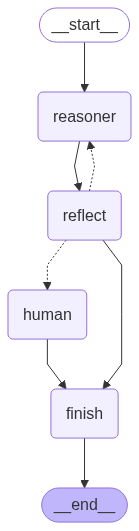

In [7]:
display(Image(classify.get_graph().draw_mermaid_png()))

In [8]:
for classify_chunk in await classify.ainvoke(
    {
        "msgs": [msg.message for msg in msgs],
        "grades": grades,
    }
):
    print("CHUNK", classify_chunk)

MULTIPLE VALUES FUNC
[] [GradeResponseBase(id=1, label='Not Informed', value=1), GradeResponseBase(id=2, label='Informed Basics', value=2), GradeResponseBase(id=3, label='Informed in Details', value=3), GradeResponseBase(id=4, label='Practice and Lab Examples', value=4), GradeResponseBase(id=5, label='Production Maintenance', value=5), GradeResponseBase(id=6, label='Production from Scratch', value=6), GradeResponseBase(id=7, label='Educator/Expert', value=7)]
MULTIPLE VALUES FUNC
 None
MULTIPLE VALUES FUNC
[GradeResponseBase(id=1, label='Not Informed', value=1), GradeResponseBase(id=2, label='Informed Basics', value=2), GradeResponseBase(id=3, label='Informed in Details', value=3), GradeResponseBase(id=4, label='Practice and Lab Examples', value=4), GradeResponseBase(id=5, label='Production Maintenance', value=5), GradeResponseBase(id=6, label='Production from Scratch', value=6), GradeResponseBase(id=7, label='Educator/Expert', value=7)] [GradeResponseBase(id=1, label='Not Informed', v

In [ ]:
display(Image(full_graph.get_graph().draw_mermaid_png()))